In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_selected = pd.read_csv('rusentiment/Dataset/rusentiment_preselected_posts.csv')
df_random = pd.read_csv('rusentiment/Dataset/rusentiment_random_posts.csv')
df_test = pd.read_csv('rusentiment/Dataset/rusentiment_test.csv')

In [3]:
print(f'Preselected length:{len(df_selected)}')
print(f'Random length:{len(df_random)}')
print(f'Test length:{len(df_test)}')

Preselected length:6950
Random length:21268
Test length:2967


In [4]:
df_train = pd.concat((df_selected, df_random))

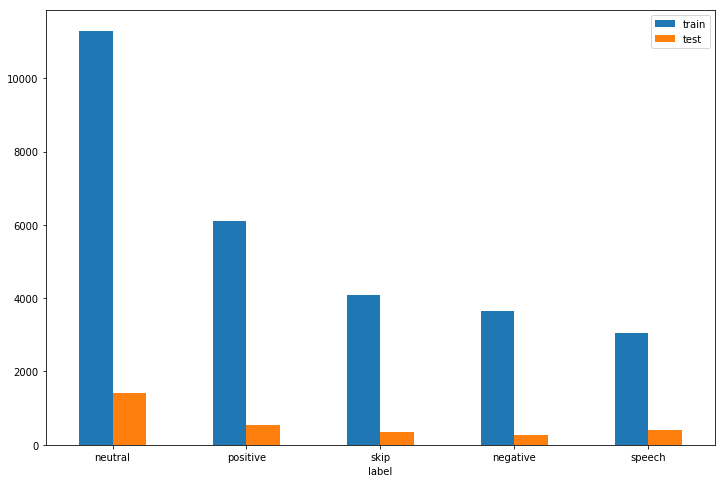

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'train': df_train.groupby('label').text.count(), 'test':df_test.groupby('label').text.count()})
freq.sort_values(by='train', ascending=False).plot.bar(rot=0, ax=ax);

In [6]:
# Optional UdPipe model download

# ! cd models; mkdir udpipe; cd udpipe; \
# wget https://github.com/jwijffels/udpipe.models.conll18.baseline/raw/master/inst/models/russian-syntagrus-ud-2.2-conll18-180430.udpipe

In [7]:
# Original code https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py
from ufal.udpipe import Model, Pipeline

udpipe_filename = 'models/udpipe/russian-syntagrus-ud-2.2-conll18-180430.udpipe'
udpipe_model = Model.load(udpipe_filename)
process_pipeline = Pipeline(udpipe_model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

def tag_ud(pipeline, text='Текст нужно передать функции в виде строки!', pos=True):
    # если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста лемму и тэг
    tagged = [w.split('\t')[2].lower() + '_' + w.split('\t')[3] for w in content if w]

    tagged_propn = []
    propn = []
    for t in tagged:
        if t.endswith('PROPN'):
            if propn:
                propn.append(t)
            else:
                propn = [t]
        elif t.endswith('PUNCT'):
            propn = []
            continue  # я здесь пропускаю знаки препинания, но вы можете поступить по-другому
        else:
            if len(propn) > 1:
                name = '::'.join([x.split('_')[0] for x in propn]) + '_PROPN'
                tagged_propn.append(name)
            elif len(propn) == 1:
                tagged_propn.append(propn[0])
            tagged_propn.append(t)
            propn = []
    if not pos:
        tagged_propn = [t.split('_')[0] for t in tagged_propn]
    return tagged_propn

df_train['lemmatized_tokens'] = df_train.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)
df_test['lemmatized_tokens'] = df_test.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)

df_train = df_train[~df_train.lemmatized_tokens.isnull()]
df_test = df_test[~df_test.lemmatized_tokens.isnull()]

In [8]:
# Optional FastText model download

#VEC
# ! mkdir models; cd models; mkdir fasttext;\
# wget http://text-machine.cs.uml.edu/lab2/data/fasttext.min_count_100.vk_posts_all_443550246.300d.vec.zip;\
# tar -xzf fasttext.min_count_100.vk_posts_all_443550246.300d.vec.zip -C fasttext;\
# rm fasttext.min_count_100.vk_posts_all_443550246.300d.vec.zip

#BIN
# wget https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz;\
# tar -xzf araneum_none_fasttextcbow_300_5_2018.tgz -C fasttext;\
# rm fasttext.min_count_100.vk_posts_all_443550246.300d.vec.zip

In [8]:
from gensim.models import KeyedVectors
from gensim.models import FastText

def load_embeddings(filename):
    try:
        if filename.endswith('model'):
            embeddings = FastText.load(filename)
        elif filename.endswith('vec'):
            embeddings = KeyedVectors.load_word2vec_format(filename)
        
    except EOFError:
        print(f'Cannot load: {filename}')
        embeddings = None
    return embeddings

def create_matrix_with_mean_embeddings(docs, fasttext_embeddings, verbose=False):
    embeddings_dim = fasttext_embeddings.vector_size
    docs_len = len(docs)
    X = np.zeros((docs_len, embeddings_dim), dtype=np.float32)

    empty_vocab = []
    tokens_embeddings = []
    for i, tokens in enumerate(docs):
        tokens_embeddings = [fasttext_embeddings[t] for t in tokens if t in fasttext_embeddings.wv]
        
        if len(tokens_embeddings) > 0:
            mean_embeddings = np.mean(tokens_embeddings, axis=0)
            X[i] = mean_embeddings
        else:
            empty_vocab.append(tokens)
            
    if verbose:
        print(f'Docs with empty vocabulary: {len(empty_vocab)}')
        print(empty_vocab)
    return X

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# fasttext_filename = "models/fasttext/fasttext.min_count_100.vk_posts_all_443550246.300d.vec"
fasttext_filename = "models/fasttext/araneum_none_fasttextcbow_300_5_2018/araneum_none_fasttextcbow_300_5_2018.model"
fasttext_embeddings = load_embeddings(fasttext_filename)

X = create_matrix_with_mean_embeddings(df_train.lemmatized_tokens, fasttext_embeddings, verbose=True)
X_test = create_matrix_with_mean_embeddings(df_test.lemmatized_tokens, fasttext_embeddings, verbose=True)

y  = le.fit_transform(df_train['label'].values)
y_test  = le.transform(df_test['label'].values) 

print(f'X_train dim:{X.shape}')
print(f'X_test dim:{X_test.shape}')
print(f'y_train dim:{y.shape}')
print(f'y_test dim:{y_test.shape}')

/home/nerdikon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Docs with empty vocabulary: 73
[['😆'], [], [], [], [], ['='], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['🔥'], ['#💞'], [], [], [], [], [], [], [], [], [], [], ['^'], [], [], [], [], [], [], [], [], [], [], ['о'], [], [], [], ['💃💃💃'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
Docs with empty vocabulary: 8
[[], [], ['х'], [], [], [], [], []]
X_train dim:(28218, 300)
X_test dim:(2967, 300)
y_train dim:(28218,)
y_test dim:(2967,)


In [123]:
import torch
import torch.nn.functional as F

class OneHiddenLayerNet(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_dim
        self.out_dim = out_dim

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, self.hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_size, self.out_dim),
        )

    def forward(self, inputs):
        logits = self.classifier(inputs)
        outputs = F.softmax(logits, dim=-1)

        return outputs

class DenseLayerNet(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_dim
        self.out_dim = out_dim

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, self.hidden_size),
            torch.nn.ReLU(),
#             torch.nn.Linear(self.hidden_size, self.hidden_size),
#             torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_size, self.out_dim),
        )
#         torch.nn.init.xavier_uniform(layer.weight)


    def forward(self, inputs):
        logits = self.classifier(inputs)
        outputs = F.softmax(logits, dim=-1)

        return outputs

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25)

print(f'X_train dim:{X_train.shape}')
print(f'X_val dim:{X_val.shape}')
print(f'y_train dim:{y_train.shape}')
print(f'y_val dim:{y_val.shape}')

X_train dim:(21163, 300)
X_val dim:(7055, 300)
y_train dim:(21163,)
y_val dim:(7055,)


In [12]:
from torch.autograd import Variable

def get_batch(X, y, i, batch_size):
    X_batch = X[i*batch_size:i*batch_size+batch_size]
    y_batch = y[i*batch_size:i*batch_size+batch_size]
    return Variable(torch.FloatTensor(X_batch)), Variable(torch.LongTensor(y_batch))

In [51]:
def train(X_train, y_train, X_val, y_val, net, num_epochs, batch_size, criterion, optimizer, scheduler):
    for epoch in range(num_epochs+1):
        train_total_batch = int(len(X_train)/batch_size)
        scheduler.step()
        for i in range(train_total_batch):
            X_batch, y_batch = get_batch(X_train, y_train, i, batch_size)
            optimizer.zero_grad()
            outputs = net(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        val_total_batch = int(len(X_val)/batch_size)
        with torch.set_grad_enabled(False):
            for i in range(val_total_batch):
                X_batch, y_batch = get_batch(X_val, y_val, i, batch_size)
                outputs = net(X_batch)
                val_loss = criterion(outputs, y_batch)
        if epoch % 5 == 0:
            print(f'epoch {epoch}/{num_epochs}, train_loss: {loss.item():.4f}, val_loss: {val_loss.item():.4f}')

In [65]:
net = OneHiddenLayerNet(embedding_dim=300, hidden_dim=512, out_dim=5)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
num_epochs = 50
batch_size = 200

train(X_train, y_train, X_val, y_val, net, num_epochs, batch_size, criterion, optimizer, scheduler)

epoch 0/50, train_loss: 1.3835, val_loss: 1.2103
epoch 5/50, train_loss: 1.3082, val_loss: 1.1770
epoch 10/50, train_loss: 1.2498, val_loss: 1.2259
epoch 15/50, train_loss: 1.2333, val_loss: 1.1946
epoch 20/50, train_loss: 1.1946, val_loss: 1.1825
epoch 25/50, train_loss: 1.1712, val_loss: 1.1896
epoch 30/50, train_loss: 1.1563, val_loss: 1.1851
epoch 35/50, train_loss: 1.1457, val_loss: 1.1844
epoch 40/50, train_loss: 1.1404, val_loss: 1.1841
epoch 45/50, train_loss: 1.1362, val_loss: 1.1844
epoch 50/50, train_loss: 1.1308, val_loss: 1.1903


In [66]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def score_model(y_pred, y_true):
    average = 'weighted'
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall
X_batch_test = Variable(torch.FloatTensor(X_test))

outputs = net(X_batch_test)
_, y_pred = torch.max(outputs.data, 1)

f1, precision, recall = score_model(y_pred,y_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1-score: {f1:.4f}')

# Without scheduler
# Precision: 0.6562
# Recall: 0.6704
# f1-score: 0.6611

# With scheduler
# Precision: 0.6635
# Recall: 0.6734
# f1-score: 0.6668

Precision: 0.6635
Recall: 0.6734
f1-score: 0.6668


In [ ]:
net = DenseLayerNet(embedding_dim=300, hidden_dim=128, out_dim=5)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
num_epochs = 50
batch_size = 128

train(X_train, y_train, X_val, y_val, net, num_epochs, batch_size, criterion, optimizer, scheduler)

epoch 0/50, train_loss: 1.3664, val_loss: 1.3221
epoch 5/50, train_loss: 1.3276, val_loss: 1.3269
epoch 10/50, train_loss: 1.2947, val_loss: 1.2735
epoch 15/50, train_loss: 1.2493, val_loss: 1.2711
epoch 20/50, train_loss: 1.2447, val_loss: 1.2425
epoch 25/50, train_loss: 1.2264, val_loss: 1.2647


In [131]:
X_batch_test = Variable(torch.FloatTensor(X_test))

outputs = net(X_batch_test)
_, y_pred = torch.max(outputs.data, 1)

f1, precision, recall = score_model(y_pred,y_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1-score: {f1:.4f}')

Precision: 0.5890
Recall: 0.6468
f1-score: 0.6157


/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


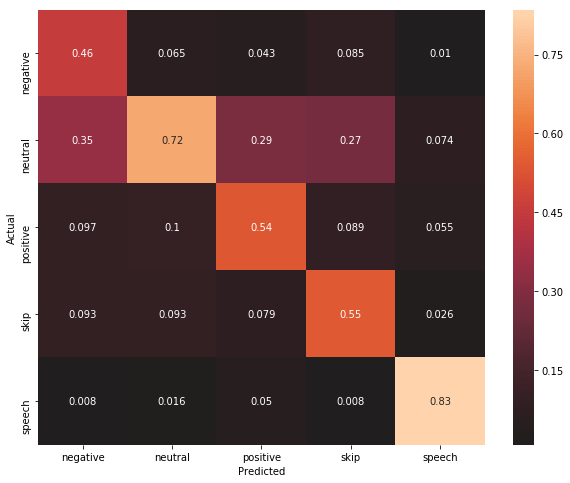

In [56]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_ratios = np.round(conf_mat / np.sum(conf_mat, axis=0),3)
fig, ax = plt.subplots(figsize=(10,8))

labels = sorted(list(set(le.inverse_transform(y_pred))))
sns.heatmap(conf_mat_ratios, annot=True, center=0, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nerdikon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


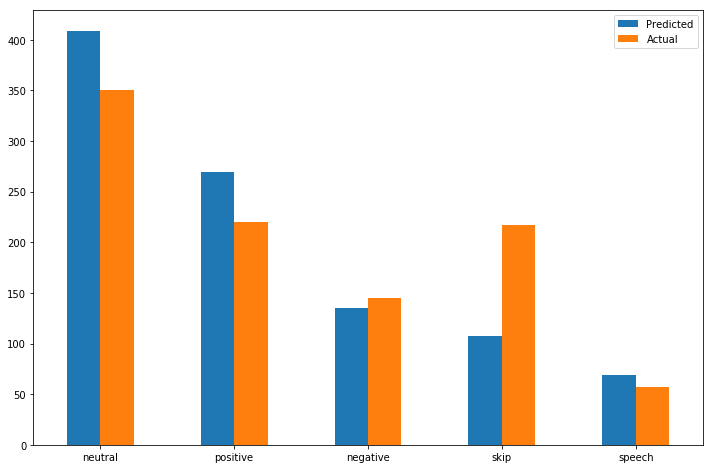

In [59]:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

results = pd.DataFrame({'text':df_test.text, 'lemmatized_tokens':df_test.lemmatized_tokens,'predicted':y_pred_labels, 'actual':y_test_labels})
errors = results[results.predicted != results.actual]
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'Predicted': errors.predicted.value_counts(), 'Actual':errors.actual.value_counts()})
freq.sort_values(by='Predicted', ascending=False).plot.bar(rot=0, ax=ax);

In [25]:
errors

,text,lemmatized_tokens,predicted,actual
3,Мы просто с [id12210212|Елисеем] психанули )...,"[мы, просто, с, id12210212|елисей, психануть, ...",neutral,skip
5,Наши красавцы. 1:3 в первом периоде и 7:3 в ит...,"[наш, красавец, 1, 3, в, первый, период, и, 7,...",neutral,positive
8,"нельзя общаться с людьми, которые нуждаются в ...","[нельзя, общаться, с, человек, который, нуждат...",neutral,negative
11,Селфи дня )),"[селфь, день]",speech,positive
17,"Я не писал такое оскобление всем!!!!\nМеня, ви...","[я, не, писать, такой, оскобление, все, я, вид...",neutral,skip
18,...и так начало мини отпуска))И новых приключе...,"[и, так, начать, минить, отпуск, и, новый, при...",neutral,positive
19,Кинул в чс обиделся холоп понял что недостоин ...,"[кидать, в, чс, обидеться, холоп, понять, что,...",neutral,negative
21,Лучше бы у Тани не было никакого оргазма: услы...,"[хороший, бы, у, тани, не, быть, никакой, орга...",neutral,skip
22,"Аю,слова правильные,но такие унылые(((Сьешь ко...","[ай, ,слово, правильный, но, такой, унылый, сь...",positive,negative
25,"по кругу, твою подругу КСЮХУ....))))))ахахахаахах","[по, круг, твой, подружать, ксюху..., )ахахаха...",neutral,skip
